# Optical Character Recognition

This notebook explores and compares different methods of optical character recognition Tesseract OCR and Google Vision API. OCR is an important tool, if we want to process large quantities of printed or hand-written textual data. The accompanying blog post can be found [here](https://fuzzylabs.ai/blog/the-battle-of-the-ocr-engines/)

The examples provided:
* Sample prescription (amoxicillin, a type of antibiotic): `gs://fuzzylabs-jupyter-delicacies/amoxicillin_prescription.png`
* Receipt from a hotel (with a hand-written note): `gs://fuzzylabs-jupyter-delicacies/receipt.jpg`

You are encouraged to try it on different images (local files and Google Cloud Storage are supported) to experiment and identify which methods and models best suit your needs.

Run this cell to install the necessary packages, if they are not already installed.

In [6]:
!pip install tesserocr matplotlib opencv-python google-cloud-vision gcsfs

In [7]:
!pip install --upgrade opencv-python-headless


In [16]:
import io
import matplotlib.pyplot as plt
import cv2
import locale
locale.setlocale(locale.LC_ALL, 'C')
from tesserocr import *
from google.cloud import vision
from PIL import Image
import numpy as np

In [17]:
def show_image(img, title=""):
    plt.figure(figsize=(5, 8))
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()

# Fonction qui prend un chemin (uri) et lit un fichier local
def imread_wrapper(uri):
    return cv2.imread(uri, cv2.IMREAD_COLOR)



Load the image (filename specified in `img`) to run the recognition on.

You can optionally set `PERFORM_THRESHOLDING` to `True`, to perform thresholding. It is advised to preprocess an image if there are unwanted objects in the background (e.g. img/amoxicillin_prescription.png)

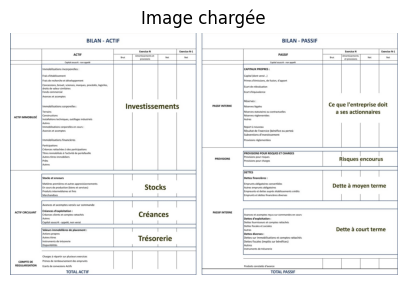

In [19]:
PERFORM_THRESHOLDING = False

# Remplace par TON image locale uploadée dans Colab
img = imread_wrapper("/content/bilan-actif.jpg")

# Si tu veux activer le seuillage (thresholding)
if PERFORM_THRESHOLDING:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)

# Affichage
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
show_image(img_rgb, "Image chargée")


# Tesseract OCR

Tesseract can run in different page segmentation modes. In many cases it is enough to run it on auto (PSM.AUTO), but it is often useful to provide it with some hint on what the layout of the input image is.

We consider three modes here:
* `PSM.SINGLE_BLOCK` -- Assume a single uniform block of text.
* `PSM.SPARSE_TEXT` -- Sparse text. Find as much text as possible in no particular order.
* `PSM.SINGLE_COLUMN` -- Assume a single column of text of variable sizes.

The illustration of how they behave is provided below.

One can read more on different PSMs in Tesseract OCR documentation.

In [23]:
!apt update
!apt install -y tesseract-ocr tesseract-ocr-fra tesseract-ocr-eng
!pip install tesserocr


Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 https://cli.github.com/packages stable InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,151 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,532 kB]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,290 kB]
Hit:13 https://ppa.launchpadcontent.net/graphi

In [24]:
!tesseract --version


tesseract 4.1.1
 leptonica-1.82.0
  libgif 5.1.9 : libjpeg 8d (libjpeg-turbo 2.1.1) : libpng 1.6.37 : libtiff 4.3.0 : zlib 1.2.11 : libwebp 1.2.2 : libopenjp2 2.4.0
 Found AVX2
 Found AVX
 Found FMA
 Found SSE
 Found libarchive 3.6.0 zlib/1.2.11 liblzma/5.2.5 bz2lib/1.0.8 liblz4/1.9.3 libzstd/1.4.8


In [28]:
from tesserocr import PyTessBaseAPI, PSM

TESSDATA_PATH = "/usr/share/tesseract-ocr/4.00/tessdata"

tesseract_modes = [
    ("Tesseract SINGLE BLOCK",
     PyTessBaseAPI(path=TESSDATA_PATH, psm=PSM.SINGLE_BLOCK, lang="fra")),

    ("Tesseract SPARSE TEXT",
     PyTessBaseAPI(path=TESSDATA_PATH, psm=PSM.SPARSE_TEXT, lang="fra")),

    ("Tesseract SINGLE COLUMN",
     PyTessBaseAPI(path=TESSDATA_PATH, psm=PSM.SINGLE_COLUMN, lang="fra"))
]


In [29]:
def tesseract_ocr(tesseract, img):
    pil_image = Image.fromarray(img)
    tesseract.SetImage(pil_image)
    tesseract.Recognize()
    return tesseract.GetIterator()


def display_tesseract_results(img, level):
    n = len(tesseract_modes)
    fig, axs = plt.subplots(1, n, figsize=(6*n, 8))

    if n == 1:
        axs = [axs]

    for (name, tesseract), ax in zip(tesseract_modes, axs):
        results = tesseract_ocr(tesseract, img)
        _img = img.copy()
        tokens = []

        for r in iterate_level(results, level):
            text = r.GetUTF8Text(level)
            if text:
                tokens.append(text.strip())

            bb = r.BoundingBox(level)
            if bb is not None:
                cv2.rectangle(_img, (bb[0], bb[1]), (bb[2], bb[3]), (255, 0, 0), 2)

        print("===== ", name, " =====")
        print(tokens[:40])
        print()

        ax.set_title(name)
        ax.imshow(_img)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


The results (i.e. recognised texts and their locations) that are returned by Tesseract are arranged in a hierarchy, and therefore can be accessed at different levels. In this notebook, we show the results by paragraph, text line and word. One may find other levels (namely blocks of text and characters) useful for their application.

## By paragraph

=====  Tesseract SINGLE BLOCK  =====
["- PASSIF\nBILAN - ACTIF BILAN - P,\nEssen Tome | ut\n7 2 2 7\ncaprraux propres:\nImmobitstions incorporees\ncape (éontvesé.)\nLast [primes d'émissions, de fusion, d'apport\nrois de recherche et développement\nconcesons, brevet, slnces, marques, procédés, oies, can de rééataton\néoks de au amies a.\nronds commerci\nsance et comptes\nréserves: . . .\nCe que l'entreprise doit\ni [réserves légaies\nimmobitsations corporelles Investissements pere EN ases actionnaires\npus [réserves règlementées\nconsructons Es\nstations techniques outages néutrs\net Report à nouveau\nre [Résultat de l'exercice (bénéfice ou perteà\nRe nes [subventions d'investissement\nmobitstions fancières roons rélementées\nrsricpaions\nerancesratachée à des prtcpatons\nPROVISIONS POUR RISQUES ET CHARGES\nrares mmobiisés à Facté de portes cu _\nPR Pe ffisaues pnoourts\nPrés\nCu\nStocks et Dettes nantes:\nemprunts cbr comes\nstères premres et autres aprortiennements Faites Dette à moye

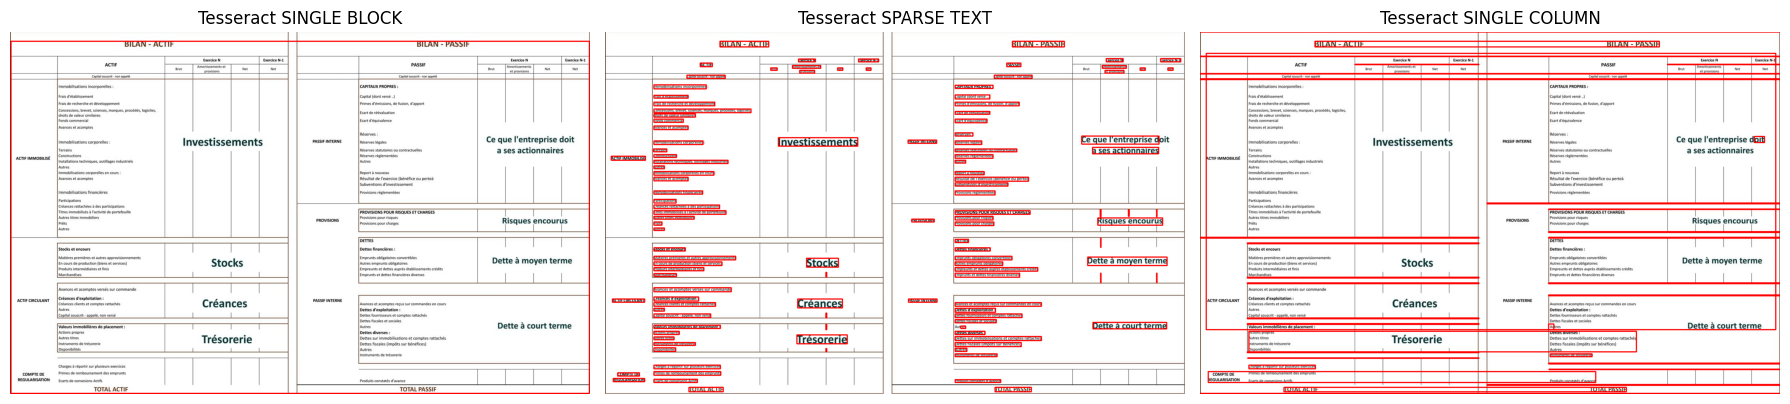

In [30]:
display_tesseract_results(img, RIL.PARA)

## By text line

=====  Tesseract SINGLE BLOCK  =====
['- PASSIF', 'BILAN - ACTIF BILAN - P,', 'Essen Tome | ut', '7 2 2 7', 'caprraux propres:', 'Immobitstions incorporees', 'cape (éontvesé.)', "Last [primes d'émissions, de fusion, d'apport", 'rois de recherche et développement', 'concesons, brevet, slnces, marques, procédés, oies, can de rééataton', 'éoks de au amies a.', 'ronds commerci', 'sance et comptes', 'réserves: . . .', "Ce que l'entreprise doit", 'i [réserves légaies', 'immobitsations corporelles Investissements pere EN ases actionnaires', 'pus [réserves règlementées', 'consructons Es', 'stations techniques outages néutrs', 'et Report à nouveau', "re [Résultat de l'exercice (bénéfice ou perteà", "Re nes [subventions d'investissement", 'mobitstions fancières roons rélementées', 'rsricpaions', 'erancesratachée à des prtcpatons', 'PROVISIONS POUR RISQUES ET CHARGES', 'rares mmobiisés à Facté de portes cu _', 'PR Pe ffisaues pnoourts', 'Prés', 'Cu', 'Stocks et Dettes nantes:', 'emprunts cbr come

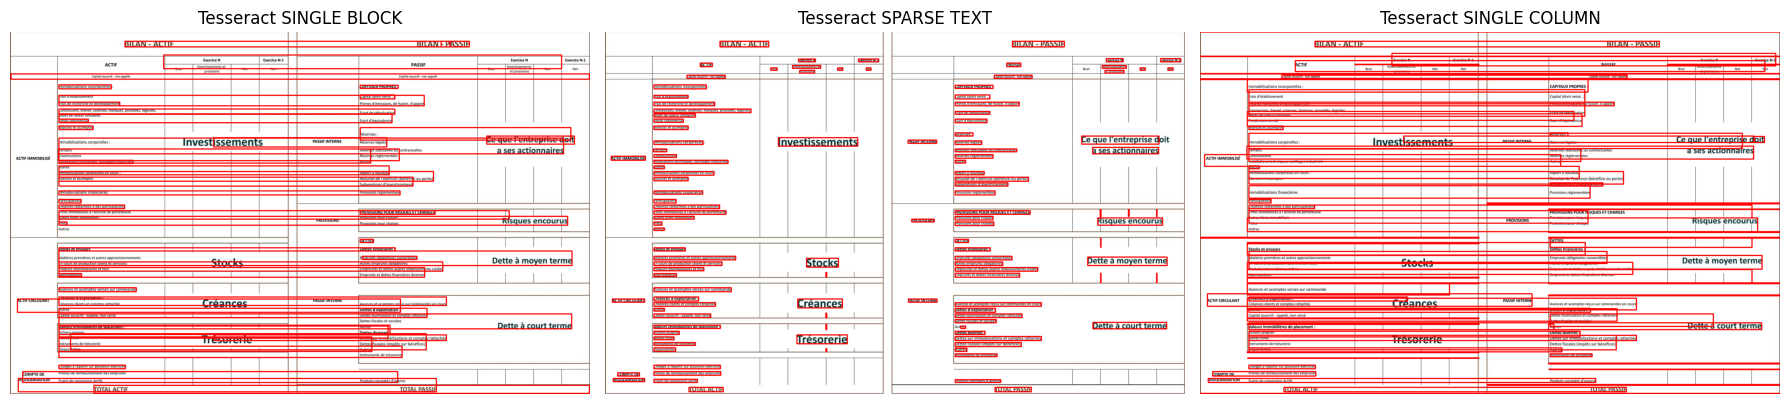

In [31]:
display_tesseract_results(img, RIL.TEXTLINE)

## By word

=====  Tesseract SINGLE BLOCK  =====
['-', 'PASSIF', 'BILAN', '-', 'ACTIF', 'BILAN', '-', 'P,', 'Essen', 'Tome', '|', 'ut', '7', '2', '2', '7', 'caprraux', 'propres:', 'Immobitstions', 'incorporees', 'cape', '(éontvesé.)', 'Last', '[primes', "d'émissions,", 'de', 'fusion,', "d'apport", 'rois', 'de', 'recherche', 'et', 'développement', 'concesons,', 'brevet,', 'slnces,', 'marques,', 'procédés,', 'oies,', 'can']

=====  Tesseract SPARSE TEXT  =====
['BILAN', '-', 'ACTIF', 'BILAN', '-', 'PASSIF', 'Brion', 'Berde', '1', 'EerckeN', 'Encre', 'NA', 'ACTIF', 'Forme', 'et', 'PASSIF', 'Prose', 'at', 'rosons', 'ne', 'va', 'x', 'raiions', 'um', 'm', 'one', 'nor', 'Go', 'ones', 'immobilisations', 'incorporelles', 'caprraux', 'PROPRES', ':', 'ais', "'étabssement", 'capital', '(éont', 'versé.)', 'ais']

=====  Tesseract SINGLE COLUMN  =====
['', 'BILAN', '-', 'ACTIF', 'BILAN', '-', 'PASSIF', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'Bent', 'Becent', 'Bean', 'Bekenr', 'A

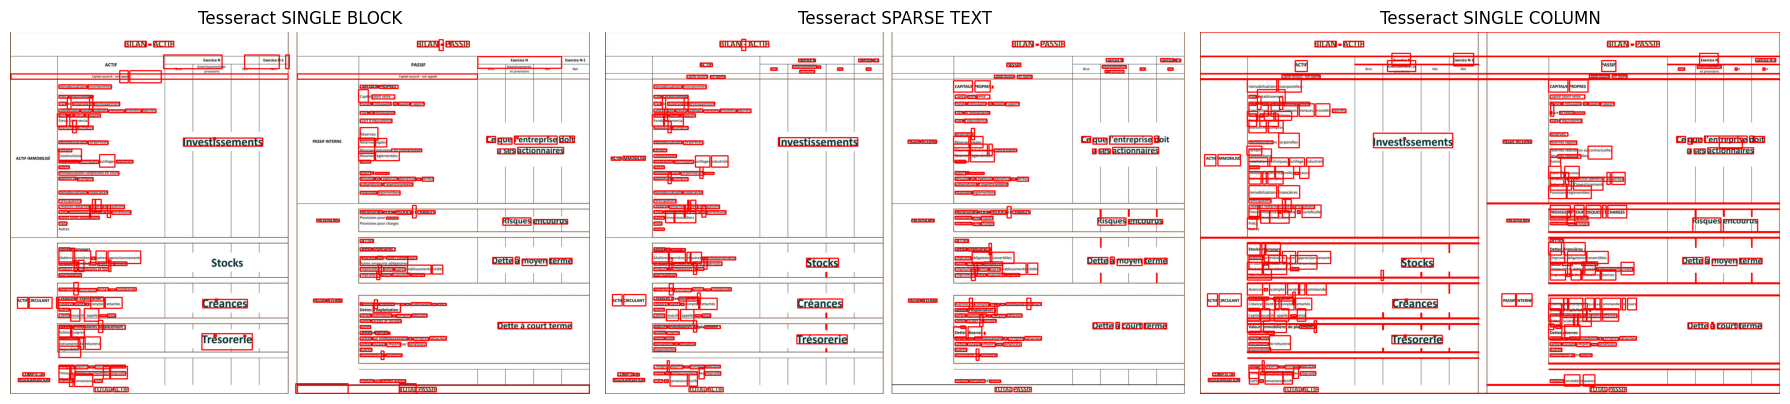

In [32]:
display_tesseract_results(img, RIL.WORD)

# Google Vision API

As an alternative to Tesseract OCR, we also explore Google Vision. As opposed to Tesseract, it does not run locally, but on the Google's servers. In order to use it, valid credentials need to be provided in `GOOGLE_APPLICATION_CREDENTIALS` environment variable (more details in the Google's documentation)



In [ ]:
google_image_annotator = vision.ImageAnnotatorClient()

In [ ]:
def google_document_text_detection(img):
    buf = io.BytesIO()
    img_pil = Image.fromarray(img)
    img_pil.save(buf, 'PNG')
    byte_image = buf.getvalue()

    document_image = vision.types.Image(content=byte_image)
    image_response = google_image_annotator.document_text_detection(image=document_image, image_context={"language_hints": ["en"]})
    page = image_response.full_text_annotation.pages[0]
    return page

def google_text_detection(img):
    buf = io.BytesIO()
    img_pil = Image.fromarray(img)
    img_pil.save(buf, 'PNG')
    byte_image = buf.getvalue()

    document_image = vision.types.Image(content=byte_image)
    image_response = google_image_annotator.text_detection(image=document_image, image_context={"language_hints": ["en"]})
    page = image_response.full_text_annotation.pages[0]
    return page

Google Vision API does not have options for differents modes of page segmentation, however there's still some degree of flexibility provided. There are two models that are tuned on two different tasks:

* Text Detection model -- detects and extracts text from any image
* Document Text Detection model -- performs the same operation, but is tuned for dense texts and documents

The choice of the model depends on the nature and structure of the images to be recognised (same as with PSM of Tesseract OCR). We show the results produced by both models in this notebook.

In [ ]:
pages = [
    ("Google Text Detection", google_text_detection(img)),
    ("Google Document Text Detection", google_document_text_detection(img)),
]

In [ ]:
def get_symbol_text(symbol):
    text = symbol.text
    if symbol.property.HasField('detected_break'):
        if symbol.property.detected_break == vision.enums.TextAnnotation.DetectedBreak.BreakType.LINE_BREAK:
            text += "\n"
        else:
            text += " "
    return text

def get_word_text(word):
    return "".join([get_symbol_text(x) for x in word.symbols])

def get_paragraph_text(para):
    return "".join([get_word_text(x) for x in para.words])

def get_block_text(block):
    return "".join([get_paragraph_text(x) for x in block.paragraphs])

In [ ]:
def add_bounding_box(img, bb):
    cv2.polylines(img, [np.array([[point.x, point.y] for point in bb])], True, (255, 0, 0), 2)


def get_google_words(page, img):
    _img = img.copy()
    texts = []
    for block in page.blocks:
        for para in block.paragraphs:
            for word in para.words:
                texts += [get_word_text(word)]
                add_bounding_box(_img, word.bounding_box.vertices)
    return texts, _img

def get_google_paragraphs(page, img):
    _img = img.copy()
    texts = []
    for block in page.blocks:
        for para in block.paragraphs:
            texts += [get_paragraph_text(para)]
            add_bounding_box(_img, para.bounding_box.vertices)
    return texts, _img

def get_google_blocks(page, img):
    _img = img.copy()
    texts = []
    for block in page.blocks:
        texts += [get_block_text(block)]
        add_bounding_box(_img, block.bounding_box.vertices)
    return texts, _img

def display_google_results(pages, img, func):
    n = len(pages)
    fig, axs = plt.subplots(1,n, figsize=(5*n, 88))
    for (name, page), ax in zip(pages, axs):
        texts, _img = func(page, img)
        print(name)
        print(texts)
        print()
        ax.imshow(_img)
        ax.set_title(name)
    plt.show()

Similar to Tesseract OCR, Google Vision also provides results in a hierarchical manner. Hence, they can be browsed at different levels. As an example, iteration over text blocks, paragraphs and individual words are shown below.

## By text block

In [ ]:
display_google_results(pages, img, get_google_blocks)

## By paragraph

In [ ]:
display_google_results(pages, img, get_google_paragraphs)

## By word

In [ ]:
display_google_results(pages, img, get_google_words)